In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load dataset into Pandas DataFrame
df = pd.read_csv("log.csv")
df.columns= ['timestamp','latency','gateway']
df = df.set_index('timestamp')
df = df.sort_index(axis=1)
df.head()


,gateway,latency
timestamp,,
01/21/19 02:32 PM,10.138.25.67,0.339817
01/21/19 02:33 PM,10.138.25.67,0.024861
01/21/19 02:34 PM,10.138.25.67,0.022789
01/21/19 02:35 PM,10.138.25.67,0.022000
01/21/19 02:36 PM,10.138.25.67,0.025834


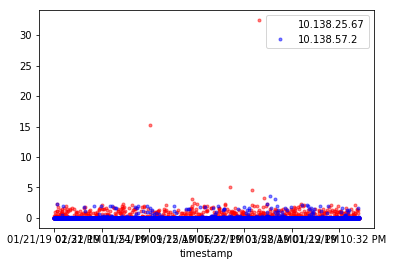

0.026701


In [2]:
fig, ax = plt.subplots()

colors = {'10.138.25.67':'red', '10.138.57.2':'blue'}

grouped = df.groupby('gateway')
for key, group in grouped:
    group.plot(ax=ax, style='.k',  y='latency', label=key, color=colors[key],alpha=0.5)

#plt.ylim(0,5)
plt.show()

print(df['latency'].quantile(0.9))



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os


INPUT_DIR = os.path.join( os.getcwd(), "logs")
data = pd.DataFrame()
dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
#print(dirs)
data = {}
for client in dirs:
    files = [f for f in os.listdir(INPUT_DIR+"/"+client) if os.path.isdir(os.path.join(INPUT_DIR,client))]
    client_data = pd.DataFrame()
    for file in files:
        temp =  pd.read_csv(os.path.join(INPUT_DIR, client,file), sep=',')
        temp.columns= ['timestamp','ttfb','latency','gateway','status']
        client_data = pd.concat([client_data,temp])
    client_data = client_data.set_index(pd.DatetimeIndex(client_data['timestamp']))
    client_data.index = client_data.index.map(lambda x: x.replace(second=0, microsecond=0))
    client_data['timestamp'] = pd.DatetimeIndex(client_data['timestamp']).map(lambda x: x.replace(second=0, microsecond=0))

    data[client] = client_data


In [185]:
def get_min_date():
    min_date = None
    for d in data:
        c = data.get(d)
        if min_date is None or min_date > c.index.min():
            min_date = c.index.min()
    return min_date#.strftime("%m/%d/%Y, %H:%M:%S")

def get_max_date():
    max_date = None
    for d in data:
        c = data.get(d)
        if max_date is None or max_date > c.index.max():
            max_date = c.index.max()
    return max_date

def get_99th_percentile():
    df = pd.DataFrame()
    for d in data:
        df = pd.concat([df,data.get(d)])
    p90 = df['latency'].quantile(0.99)    
    return df.query('latency<'+str(p90))['latency'].mean()

def send_info(ts):
    min_date = None
    max_date = None
    
    gateway_table = pd.DataFrame()
    for d in data:
        c = data.get(d)[ts]
        c['sender'] = d
        if len(c)>2:
            gateway_table = pd.concat([gateway_table , c.sample(n=2)])
        elif len(c)>0:
            gateway_table = pd.concat([gateway_table , c])
    return gateway_table
    
import numpy as np
import math
def cosine_similarity(a,b):
    return sum([i*j for i,j in zip(a, b)])/(math.sqrt(sum([i*i for i in a]))* math.sqrt(sum([i*i for i in b])))
    
        
        

In [230]:
def calculate_trust_score(trust_score, gateway_table, noce):
    gateways = gateway_table.query('sender == "'+node+'"')
    rest = gateway_table.query('sender != "'+node+'"')
    rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    for index, row in rest.iterrows():
        gw = gateways.query('gateway == "'+row['gateway']+'"')
        value = abs(gw['latency'].values[0] - row['latency'])

        if row['sender'] in trust_score:
            trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
        else:
            trust_score[row['sender']] = value
    
    return trust_score

def calculate_trust_score_transitive(trust_score, gateway_table, node, topk):
    if len(trust_score)< topk:
        topk = len(trust_score)
    trust_score = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:topk])
    #print(trust_score)
    trusted = []
    trusted.extend(list(trust_score.keys()))
    if node not in trust_score:
        trusted.append(node)
        
    trusted_gw = gateway_table[gateway_table.sender.isin(trusted)]    
    gateways= trusted_gw['gateway'].unique()    
    
    mean_gateways = trusted_gw.groupby('gateway').mean()
    
    rest = gateway_table[~gateway_table.sender.isin(trusted)]
    rest = rest[rest.gateway.isin(gateways)]
    trusted_gw = trusted_gw.append(rest)
    
    for name, group in trusted_gw.groupby('sender'):
        if name == node:
            continue
        score = 0
        cnt = 0
        for index, row in group.iterrows():
            gw_value = mean_gateways.query('gateway == "'+row['gateway']+'"')['latency'].values[0]
            
            score += abs(gw_value - row['latency'])
            cnt +=1
            
        v = score/cnt
        #print(name, v)
        if name in trust_score:
            trust_score[name] = 2/3*v + 1/3*trust_score[name]
        else:
            trust_score[name] = v
    #print(trust_score)
        #print(name)
        #print(type(group))
    #print(mean_gateways)
    #print(trusted_gw[['gateway','latency','sender']])
    
    
    
    #gateway_table[~gateway_table.sender.isin(trusted)]
    #rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    
    #print(gateways[['gateway', 'sender']])
    #print('=====================')
    #print(rest[['gateway', 'sender']])
    #print(rest[['gateway','sender']])
    #cnt = 0
    #for index, row in rest.iterrows():
    #    gw = gateways.query('gateway == "'+row['gateway']+'"')
    #    value = abs(gw['latency'].values[0] - row['latency'])

    #    if row['sender'] in trust_score:
    #        trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
    #        cnt+=1
    #    else:
    #        trust_score[row['sender']] = value
    #        cnt+=1
    
    #print(cnt)
    
    return trust_score
    

In [244]:

# Gateway table with all collaborators and MA
def build_gateway_table(gateway_table, new_df, ts):
    #print(new_df['gateway'].unique())
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)
    
#Gateway table with latest measurement without ma
def build_gateway_table1(gateway_table, new_df, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        size = len(group)
        mv_value = group['latency'].values[size-1]
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
            
            #print(name, mv_value, df_actual['latency'].values[0])
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

#Gateway table with MA and TOP K collaborators (absolute error)
def build_gateway_table2(gateway_table, new_df, trust_score, ts):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:5])
    print(trusted_col)
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [6]:
# Gateway table with all collaborators without MA
def build_gateway_table_no_ma(gateway_table, new_df,trust_score, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

# Gateway table with TOP K collaborators without MA
def build_gateway_table_no_ma_topk(gateway_table, new_df,trust_score, ts, k):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:k])
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

def build_gateway_table_ma_topk_error(gateway_table, new_df, trust_score, faulty_nodes):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:4])
    
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [88]:
#print(data['c2_2'][['gateway','latency']]) 
#data['c2_2']['latency'] = data['c2_2']['latency']*10 
#data['c5_1']['latency'] = data['c5_1']['latency']*10 
#data['c1_2']['latency'] = data['c1_2']['latency']*10 

In [229]:
print(data['c2_2']['latency'])

timestamp
2019-01-21 14:35:00    0.257984
2019-01-21 14:36:00    0.178664
2019-01-21 14:37:00    0.182187
2019-01-21 14:38:00    0.179872
2019-01-21 14:39:00    0.186970
2019-01-21 14:40:00    0.176158
2019-01-21 14:41:00    1.848960
2019-01-21 14:42:00    1.837210
2019-01-21 14:43:00    1.793280
2019-01-21 14:44:00    1.852150
2019-01-21 14:45:00    1.796980
2019-01-21 14:46:00    0.179601
2019-01-21 14:47:00    0.180826
2019-01-21 14:48:00    0.181106
2019-01-21 14:49:00    0.180974
2019-01-21 14:50:00    0.185573
2019-01-21 14:51:00    1.807050
2019-01-21 14:52:00    1.822670
2019-01-21 14:53:00    1.850200
2019-01-21 14:54:00    1.797400
2019-01-21 14:55:00    1.785800
2019-01-21 14:56:00    0.190883
2019-01-21 14:57:00    0.185969
2019-01-21 14:58:00    0.190768
2019-01-21 14:59:00    0.194400
2019-01-21 15:00:00    0.187567
2019-01-21 15:01:00    1.890330
2019-01-21 15:02:00    1.835280
2019-01-21 15:03:00    1.869350
2019-01-21 15:04:00    1.803430
                         ...  

In [251]:
import datetime

min_date = get_min_date() 
max_date = get_max_date() 

start = min_date
end_date = start+datetime.timedelta(minutes = 1440)

#end_date = start+datetime.timedelta(minutes = 100)
history_gateway_table = pd.DataFrame()
gateway_table = {}
trust_score = {}
trust_score_transitive = {}
clients = {}
gw_table_similarity_ma = pd.DataFrame()
gw_table_similarity = pd.DataFrame()
gw_table_similarity_ma_top = pd.DataFrame()

gw_table_similarity_no_ma = pd.DataFrame()
gw_table_similarity_no_ma_top4 = pd.DataFrame()
gw_table_similarity_no_ma_top5 = pd.DataFrame()
gw_table_similarity_no_ma_top6 = pd.DataFrame()
gw_table_similarity_no_ma_top7 = pd.DataFrame()
#f = open('similarity_abs.csv','w')
while(start < end_date):
    rt = send_info(start.strftime("%m/%d/%Y, %H:%M:%S"))
    gws = rt.query('sender=="c0_1"')['gateway'].values
    
    for index, row in rt.iterrows():
        if row["gateway"] in gws:
            if row['sender'] == "c0_1":
                continue
            if row["sender"] not in clients:
                clients[row["sender"]] = 1
            else:
                clients[row["sender"]] += 1
    
    #print(rt[['gateway','latency','sender']])
    
    
    history_gateway_table = pd.concat([history_gateway_table, rt])
    no_gws = len(history_gateway_table['gateway'].unique())
    #no_senders = len(history_gat)
    #trust_score = calculate_trust_score(trust_score, rt, 'c0_1')
    trust_score_transitive = calculate_trust_score_transitive(trust_score_transitive, rt, 'c0_1', 5)
    #print(rt.query('sender=="c2_2"')['latency'])
    print(sorted(trust_score_transitive.values()))
    
    #print(len(trust_score_transitive))
    
    #gw_table_similarity_no_ma = gw_table_similarity_no_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
    #                                                             'similarity':build_gateway_table_no_ma(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
    #                                                             ignore_index=True)
    #gw_table_similarity_no_ma_top4 = gw_table_similarity_no_ma_top4.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
    #                                                             'similarity':build_gateway_table_no_ma_topk(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"), 4)}, 
    #                                                             ignore_index=True)
    
    #gw_table_similarity_ma = gw_table_similarity_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
    #                                                       'similarity':build_gateway_table(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
    #                                                      ignore_index=True) 
    #gw_table_similarity = gw_table_similarity.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
    #                                                  'similarity':build_gateway_table1(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, ignore_index=True)
    
    gw_table_similarity_ma_top = gw_table_similarity_ma_top.append({
        'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
        'similarity':build_gateway_table2(gateway_table, rt, trust_score_transitive, start.strftime("%m/%d/%Y, %H:%M:%S"))
    },  ignore_index=True)
    start = start+datetime.timedelta(minutes=2)
gw_table_similarity_ma_top.to_csv('similarity_error_15%_pattern.csv')
#gw_table_similarity_ma.to_csv("similarity_abs_ma.csv")
#gw_table_similarity.to_csv("similarity_error_15%.csv")
#gw_table_similarity.to_csv("similarity.csv")
#print(gw_table_similarity)
    


/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0.034449]
{'c0_2': 0.034449}
[0.00092200000000000268, 0.0016639999999999953, 0.0022994999999999995, 0.0083394999999999997, 0.011483]
{'c1_1': 0.00092200000000000268, 'c1_2': 0.0016639999999999953, 'c0_3': 0.0022994999999999995, 'c1_3': 0.0083394999999999997, 'c0_2': 0.011483}
[0.0024931666666666665, 0.0051181666666666667, 0.0063341666666666668, 0.0065923333333333329, 0.0085021666666666631, 0.012140000000000001, 0.013786, 0.020751500000000003]
{'c1_1': 0.0024931666666666665, 'c1_3': 0.0051181666666666667, 'c0_2': 0.0063341666666666668, 'c1_2': 0.0065923333333333329, 'c0_3': 0.0085021666666666631}
[0.0021113888888888888, 0.0034271111111111034, 0.0043820000000000074, 0.0068887222222222223, 0.013783999999999991, 0.016982722222222218, 0.021525777777777779, 0.08265133333333341]
{'c0_2': 0.0021113888888888888, 'c1_1': 0.0034271111111111034, 'c2_1': 0.0043820000000000074, 'c1_3': 0.0068887222222222223, 'c2_2': 0.013783999999999991}
[0.0031016851851851839, 0.005229000000000001, 0.0053231481481

[0.0026099722222222236, 0.0027740833333333337, 0.0028047777777777784, 0.0035344044352994966, 0.010184874999999999, 0.013255649291266575, 0.018728999999999996, 0.11441950000000001]
{'c1_1': 0.0026099722222222236, 'c2_2': 0.0027740833333333337, 'c1_3': 0.0028047777777777784, 'c1_2': 0.0035344044352994966, 'c0_3': 0.010184874999999999}
[0.0017120925925925927, 0.0043255000000000012, 0.0073214999999999981, 0.0080202916666666669, 0.030196499999999994, 0.082074768518518512, 0.095757745922877599, 0.17403908333333334]
{'c1_3': 0.0017120925925925927, 'c0_2': 0.0043255000000000012, 'c2_1': 0.0073214999999999981, 'c0_3': 0.0080202916666666669, 'c5_1': 0.030196499999999994}
[0.0022523888888888888, 0.0030113194444444454, 0.0035889444444444441, 0.027929166666666644, 0.27161058641975305, 0.555792611111111, 0.70782450000000008, 0.98821550000000002]
{'c0_2': 0.0022523888888888888, 'c0_3': 0.0030113194444444454, 'c2_1': 0.0035889444444444441, 'c2_2': 0.027929166666666644, 'c1_3': 0.27161058641975305}
[0.

[0.0034406759259259226, 0.0042752222222222219, 0.0050308607681755794, 0.0051646851851851854, 0.0068313333333333334, 0.008071, 0.0124755, 0.035941611111111132]
{'c0_3': 0.0034406759259259226, 'c1_3': 0.0042752222222222219, 'c0_2': 0.0050308607681755794, 'c1_2': 0.0051646851851851854, 'c2_2': 0.0068313333333333334}
[0.0011864999999999966, 0.0051462777777777774, 0.00545, 0.01648497839506172, 0.047524141975308638, 0.054033036922725194, 0.084445157407407406, 0.15936637499999998]
{'c5_1': 0.0011864999999999966, 'c2_2': 0.0051462777777777774, 'c1_1': 0.00545, 'c1_2': 0.01648497839506172, 'c0_3': 0.047524141975308638}
[0.002450333333333333, 0.0086049999999999998, 0.01749938065843621, 0.036934000000000002, 0.070707500000000006, 0.3162063261316872, 0.34106525925925935, 0.34518433333333332]
{'c1_1': 0.002450333333333333, 'c1_3': 0.0086049999999999998, 'c0_3': 0.01749938065843621, 'c0_2': 0.036934000000000002, 'c2_1': 0.070707500000000006}
[0.0099295157750342901, 0.014422722222222222, 0.0255056666

[0.0024469999999999935, 0.0046953888888888878, 0.0054849444444444459, 0.011633635802469136, 0.020049000000000004, 0.020307749999999992, 0.021660000000000002, 0.029916250000000002]
{'c0_2': 0.0024469999999999935, 'c1_2': 0.0046953888888888878, 'c1_3': 0.0054849444444444459, 'c0_3': 0.011633635802469136, 'c2_1': 0.020049000000000004}
[0.0019303888888888977, 0.0030875925925925854, 0.014035767489711932, 0.016696333333333334, 0.038956333333333398, 0.052435666666666672, 0.056758129629629638, 0.10034049999999999]
{'c0_2': 0.0019303888888888977, 'c1_3': 0.0030875925925925854, 'c0_3': 0.014035767489711932, 'c2_1': 0.016696333333333334, 'c2_2': 0.038956333333333398}
[0.004197808641975307, 0.006276589163237309, 0.0093021851851851963, 0.015234111111111111, 0.040090499999999987, 0.065126777777777797, 0.089931750000000019, 0.16]
{'c1_3': 0.004197808641975307, 'c0_3': 0.006276589163237309, 'c0_2': 0.0093021851851851963, 'c2_1': 0.015234111111111111, 'c1_2': 0.040090499999999987}
[0.003881728395061731

[0.0012941944444444444, 0.0032313333333333335, 0.0088640000000000004, 0.11731299718030787, 0.14810324999999996, 0.20343045061728396, 0.26148830006858709, 0.28665275000000001]
{'c1_3': 0.0012941944444444444, 'c2_2': 0.0032313333333333335, 'c0_2': 0.0088640000000000004, 'c1_2': 0.11731299718030787, 'c0_3': 0.14810324999999996}
[0.0013894444444444445, 0.0039979999999999981, 0.024392500000000004, 0.025000999999999999, 0.0716129990601026, 0.16930189814814814, 0.22610988888888883, 0.32946202777777778]
{'c2_2': 0.0013894444444444445, 'c1_1': 0.0039979999999999981, 'c2_1': 0.024392500000000004, 'c5_1': 0.025000999999999999, 'c1_2': 0.0716129990601026}
[0.001332666666666666, 0.0048762500000000004, 0.0073162500000000207, 0.017687249999999981, 0.032463666666666668, 0.044281333020034196, 0.34372788888888883, 0.63872825925925936]
{'c1_1': 0.001332666666666666, 'c1_3': 0.0048762500000000004, 'c0_3': 0.0073162500000000207, 'c0_2': 0.017687249999999981, 'c5_1': 0.032463666666666668}
[0.001168333333333

[0.00062974193231233482, 0.0019851203703703749, 0.0033806666666666672, 0.0048722777777777783, 0.007779694444444445, 0.030577666666666652, 0.03385225, 0.04183566666666666]
{'c1_1': 0.00062974193231233482, 'c0_3': 0.0019851203703703749, 'c1_2': 0.0033806666666666672, 'c0_2': 0.0048722777777777783, 'c2_2': 0.007779694444444445}
[0.00081546953299299965, 0.0011355555555555563, 0.0016477067901234576, 0.0033242037037037042, 0.0087965648148148161, 1.4171909999999999, 1.418364, 2.7742339999999999]
{'c1_1': 0.00081546953299299965, 'c1_2': 0.0011355555555555563, 'c0_3': 0.0016477067901234576, 'c0_2': 0.0033242037037037042, 'c2_2': 0.0087965648148148161}
[0.0011059022633744852, 0.0011744074074074063, 0.001852378733219888, 0.0029027345679012344, 0.0068258549382716055, 0.036504333333333326, 0.040469500000000005, 0.090186000000000016]
{'c0_3': 0.0011059022633744852, 'c1_2': 0.0011744074074074063, 'c1_1': 0.001852378733219888, 'c0_2': 0.0029027345679012344, 'c2_2': 0.0068258549382716055}
[0.0003914691

[0.0035234444444444449, 0.0045033333333333331, 0.0071823525377229048, 0.010955805555555552, 0.023081972222222209, 0.026552499999999993, 0.089972999999999984, 1.3855725000000001]
{'c0_2': 0.0035234444444444449, 'c0_3': 0.0045033333333333331, 'c1_2': 0.0071823525377229048, 'c2_2': 0.010955805555555552, 'c1_3': 0.023081972222222209}
[0.0020279444444444451, 0.0027346481481481484, 0.0050681175125743029, 0.008709500000000002, 0.010886499999999985, 0.015082935185185182, 0.016803657407407399, 0.038373750000000005]
{'c0_3': 0.0020279444444444451, 'c0_2': 0.0027346481481481484, 'c1_2': 0.0050681175125743029, 'c2_1': 0.008709500000000002, 'c1_1': 0.010886499999999985}
[0.0031109814814814819, 0.0065550391708581032, 0.0075525000000000019, 0.014444500000000027, 0.01645333333333333, 0.018386999999999997, 0.019500382716049369, 0.031421499999999991]
{'c0_3': 0.0031109814814814819, 'c1_2': 0.0065550391708581032, 'c1_3': 0.0075525000000000019, 'c2_2': 0.014444500000000027, 'c1_1': 0.01645333333333333}
[0

[0.0066045555555555423, 0.0083476843850022828, 0.0084318703703703674, 0.009368166666666667, 0.010632666666666667, 0.017532685032769387, 0.026463166666666694]
{'c2_1': 0.0066045555555555423, 'c0_2': 0.0083476843850022828, 'c5_1': 0.0084318703703703674, 'c1_2': 0.009368166666666667, 'c0_3': 0.010632666666666667}
[0.0028106234567901222, 0.0037479999999999736, 0.0040887222222222219, 0.0096592222222222253, 0.010435561461667422, 0.016119018518518508, 0.020372500000000002, 0.029747999999999997]
{'c5_1': 0.0028106234567901222, 'c1_1': 0.0037479999999999736, 'c1_2': 0.0040887222222222219, 'c0_3': 0.0096592222222222253, 'c0_2': 0.010435561461667422}
[0.0019900740740740742, 0.0041659999999999996, 0.0066495000000000026, 0.0094905185185185197, 0.010944131598333587, 0.027208833333333331, 0.074007444444444431, 0.16520298559670774]
{'c1_2': 0.0019900740740740742, 'c2_2': 0.0041659999999999996, 'c1_3': 0.0066495000000000026, 'c0_3': 0.0094905185185185197, 'c0_2': 0.010944131598333587}
[0.00412624999999

[0.0090042654320987639, 0.0099190000000000111, 0.010225465020576132, 0.016537499999999983, 0.018712833333333324, 0.034580000000000055, 0.058246259259259255, 0.066773055555555558]
{'c1_1': 0.0090042654320987639, 'c5_1': 0.0099190000000000111, 'c2_1': 0.010225465020576132, 'c1_3': 0.016537499999999983, 'c2_2': 0.018712833333333324}
[0.0035757499999999869, 0.0036758888888888488, 0.0072826550068587105, 0.011106699588477365, 0.011177666666666673, 0.013361833333333331, 0.01850361111111113, 1.2818686666666665]
{'c0_3': 0.0035757499999999869, 'c5_1': 0.0036758888888888488, 'c2_1': 0.0072826550068587105, 'c1_1': 0.011106699588477365, 'c0_2': 0.011177666666666673}
[0.0087893333333333087, 0.014050333333333345, 0.016636740740740733, 0.60457288888888883, 0.60570345541838122, 0.60889455166895279, 1.3423194999999999, 1.7970972499999998]
{'c1_3': 0.0087893333333333087, 'c2_2': 0.014050333333333345, 'c5_1': 0.016636740740740733, 'c0_2': 0.60457288888888883, 'c1_1': 0.60570345541838122}
[0.0034857777777

[0.0011858333333333339, 0.0016601666666666668, 0.0019160797390189168, 0.0063681666666666721, 0.014056178898033837, 0.016842499999999993, 0.021111750000000006, 0.027915249999999996]
{'c1_1': 0.0011858333333333339, 'c0_2': 0.0016601666666666668, 'c0_3': 0.0019160797390189168, 'c2_2': 0.0063681666666666721, 'c1_2': 0.014056178898033837}
[0.0018636388888888904, 0.0018780000000000012, 0.00233330435745075, 0.0038839722222222218, 0.0052216429660112791, 0.0064991944444444446, 0.023626000000000005, 0.046972750000000001]
{'c1_1': 0.0018636388888888904, 'c1_3': 0.0018780000000000012, 'c0_3': 0.00233330435745075, 'c0_2': 0.0038839722222222218, 'c1_2': 0.0052216429660112791}
[0.0030008240740740733, 0.0075432500000000074, 0.01936376851851852, 0.048072999999999998, 0.2938607777777778, 0.30316687923026137, 0.47956600000000005, 0.60871565876644806]
{'c0_2': 0.0030008240740740733, 'c2_2': 0.0075432500000000074, 'c1_1': 0.01936376851851852, 'c5_1': 0.048072999999999998, 'c1_3': 0.2938607777777778}
[0.005

[0.0015821871307944266, 0.0029828333333333291, 0.0049143701417466712, 0.0083297500000000003, 0.01911971399176951, 0.020606833333333355, 0.035112499999999998, 1.3414082500000002]
{'c0_2': 0.0015821871307944266, 'c2_2': 0.0029828333333333291, 'c1_3': 0.0049143701417466712, 'c0_3': 0.0083297500000000003, 'c2_1': 0.01911971399176951}
[0.0027765833333333332, 0.0037711734880425869, 0.028150999999999999, 0.034373793552812046, 0.48865433333333325, 0.49797840115835995, 0.64014524999999989, 1.2137864999999999]
{'c0_3': 0.0027765833333333332, 'c0_2': 0.0037711734880425869, 'c5_1': 0.028150999999999999, 'c2_1': 0.034373793552812046, 'c2_2': 0.48865433333333325}
[0.0029604744960141948, 0.021440277777777784, 0.021933681184270686, 0.035272625000000023, 0.052466749999999951, 0.422539, 0.47730583333333337, 0.63080694444444441]
{'c0_2': 0.0029604744960141948, 'c0_3': 0.021440277777777784, 'c2_1': 0.021933681184270686, 'c1_3': 0.035272625000000023, 'c1_2': 0.052466749999999951}
[0.0059156581653380634, 0.

[0.0022503291546004376, 0.0037142551440329232, 0.0051116296296296292, 0.0059249999999999962, 0.0079182500000000017, 0.0093385764800935789, 0.011574577046181977, 0.035696000000000006]
{'c1_2': 0.0022503291546004376, 'c0_2': 0.0037142551440329232, 'c2_2': 0.0051116296296296292, 'c1_3': 0.0059249999999999962, 'c2_1': 0.0079182500000000017}
[0.001444443051533479, 0.0029559999999999977, 0.0036280432098765429, 0.0037694183813443073, 0.0044764166666666667, 0.009758499999999979, 0.022920999999999997, 0.15856149999999997]
{'c1_2': 0.001444443051533479, 'c1_3': 0.0029559999999999977, 'c2_2': 0.0036280432098765429, 'c0_2': 0.0037694183813443073, 'c2_1': 0.0044764166666666667}
[0.0018686666666666656, 0.002952500000000002, 0.0038954999999999997, 0.0039504727937814347, 0.0086912366255144074, 0.010238361111111108, 0.018520258794955603, 0.042661499999999998]
{'c1_3': 0.0018686666666666656, 'c1_1': 0.002952500000000002, 'c0_3': 0.0038954999999999997, 'c0_2': 0.0039504727937814347, 'c2_2': 0.00869123662

[0.0016193936928087969, 0.0016318436213991767, 0.0023610574153371199, 0.0073399999999999984, 0.0078445000000000008, 0.015855630848955946, 0.02345000000000063, 1.9079665000000003]
{'c1_2': 0.0016193936928087969, 'c1_3': 0.0016318436213991767, 'c0_3': 0.0023610574153371199, 'c2_2': 0.0073399999999999984, 'c2_1': 0.0078445000000000008}
[0.0036351858051123721, 0.0049410833333333321, 0.0058277777777777789, 0.0064199444444444434, 0.017558916666666671, 0.71152146456426968, 0.7116076145404665, 0.90416249999999954]
{'c0_3': 0.0036351858051123721, 'c0_2': 0.0049410833333333321, 'c2_1': 0.0058277777777777789, 'c2_2': 0.0064199444444444434, 'c5_1': 0.017558916666666671}
[0.0033888611111111103, 0.0045821174905930091, 0.0055228703703703828, 0.0092612592592592486, 0.013203638888888897, 0.01393833333333333, 0.057796500000000001, 0.091867499999999991]
{'c0_2': 0.0033888611111111103, 'c0_3': 0.0045821174905930091, 'c2_1': 0.0055228703703703828, 'c2_2': 0.0092612592592592486, 'c5_1': 0.013203638888888897

[0.0009289999999999958, 0.0027462077088519703, 0.0029126111111111115, 0.0039783333333333355, 0.0040349999999999987, 0.0047535833333333328, 0.0061637789914590711, 0.023398999999999996]
{'c5_1': 0.0009289999999999958, 'c1_3': 0.0027462077088519703, 'c2_2': 0.0029126111111111115, 'c1_2': 0.0039783333333333355, 'c0_3': 0.0040349999999999987}
[0.0025040000000000028, 0.010598999999999997, 0.010755999999999998, 0.013480333333333332, 0.019138000000000002, 0.39307466666666679, 0.48575109259259253, 0.87355451368072845]
{'c0_2': 0.0025040000000000028, 'c2_1': 0.010598999999999997, 'c0_3': 0.010755999999999998, 'c5_1': 0.013480333333333332, 'c1_1': 0.019138000000000002}
[0.0016985000000000008, 0.0038894999999999993, 0.0074633333333333305, 0.010728833333333312, 0.010966611111111113, 0.011520500000000001, 0.012000249999999995, 0.024367749999999987]
{'c0_2': 0.0016985000000000008, 'c0_3': 0.0038894999999999993, 'c2_1': 0.0074633333333333305, 'c1_1': 0.010728833333333312, 'c5_1': 0.010966611111111113}

[0.0039568888888888883, 0.0049373333333333335, 0.0078766666666666672, 0.012189000000000002, 0.017932333333333328, 0.022812598765432106, 0.11598941975308641, 0.13391394444444443]
{'c0_3': 0.0039568888888888883, 'c2_1': 0.0049373333333333335, 'c2_2': 0.0078766666666666672, 'c1_2': 0.012189000000000002, 'c1_1': 0.017932333333333328}
[0.0013421250000000013, 0.0038377129629629672, 0.0046698888888888884, 0.0051512500000000004, 0.0061333611111111085, 0.008021777777777777, 0.031318499999999999, 0.031337500000000032]
{'c1_3': 0.0013421250000000013, 'c0_3': 0.0038377129629629672, 'c2_2': 0.0046698888888888884, 'c1_2': 0.0051512500000000004, 'c2_1': 0.0061333611111111085}
[0.0027075709876543223, 0.0034727870370370364, 0.0034789999999999995, 0.0040854629629629427, 0.010047666666666653, 0.025218819444444429, 0.04410197222222223, 0.057473666666666645]
{'c0_3': 0.0027075709876543223, 'c2_1': 0.0034727870370370364, 'c0_2': 0.0034789999999999995, 'c2_2': 0.0040854629629629427, 'c5_1': 0.010047666666666

[0.0011275458161865578, 0.0012774965960473509, 0.0039484999999999989, 0.01416116666666666, 0.015245750000000002, 0.023881223251028816, 0.024936000000000003, 0.058431363694935089]
{'c0_2': 0.0011275458161865578, 'c0_3': 0.0012774965960473509, 'c1_2': 0.0039484999999999989, 'c2_2': 0.01416116666666666, 'c2_1': 0.015245750000000002}
[0.0037805152720621848, 0.0051989166666666685, 0.0061254999999999695, 0.0068774999999999991, 0.007170665532015787, 0.0080609999999999953, 0.0081898888888889063, 0.0088135000000000019]
{'c0_2': 0.0037805152720621848, 'c2_1': 0.0051989166666666685, 'c1_1': 0.0061254999999999695, 'c1_3': 0.0068774999999999991, 'c0_3': 0.007170665532015787}
[0.0030444999999999908, 0.0035828384240207275, 0.0042599999999999982, 0.0046148885106719285, 0.0046398888888888887, 0.0058841249999999987, 0.02023925, 0.036458000000000004]
{'c1_1': 0.0030444999999999908, 'c0_2': 0.0035828384240207275, 'c1_3': 0.0042599999999999982, 'c0_3': 0.0046148885106719285, 'c2_1': 0.0046398888888888887}


[0.0023143052126200271, 0.0024690833333333322, 0.0063115277777777787, 0.010578000000000001, 0.022848, 0.030168583333333318, 0.033184666666666675, 0.14381149999999943]
{'c0_2': 0.0023143052126200271, 'c1_1': 0.0024690833333333322, 'c2_1': 0.0063115277777777787, 'c0_3': 0.010578000000000001, 'c5_1': 0.022848}
[0.0047243425925925925, 0.0048853611111111094, 0.0096871666666666668, 0.010088601737540007, 0.012609500000000001, 0.01302125, 0.021792833333333331, 0.22349800000000003]
{'c2_1': 0.0047243425925925925, 'c1_1': 0.0048853611111111094, 'c0_3': 0.0096871666666666668, 'c0_2': 0.010088601737540007, 'c1_2': 0.012609500000000001}
[0.002785114197530881, 0.0028651203703703863, 0.0036647222222222216, 0.0042031666666666667, 0.0060187005791800018, 0.0095517499999999977, 0.012887000000000004, 0.031230999999999984]
{'c2_1': 0.002785114197530881, 'c1_1': 0.0028651203703703863, 'c0_3': 0.0036647222222222216, 'c1_2': 0.0042031666666666667, 'c0_2': 0.0060187005791800018}
[0.0014010555555555556, 0.00262

[0.0013908333333333325, 0.002897750000000001, 0.003233055555555555, 0.0055831296296296488, 0.006843396103236284, 0.011292534979423877, 0.018380666666666656, 0.024720166666666682]
{'c1_3': 0.0013908333333333325, 'c1_2': 0.002897750000000001, 'c0_2': 0.003233055555555555, 'c2_2': 0.0055831296296296488, 'c2_1': 0.006843396103236284}
[0.0030424166666666664, 0.003706296296296293, 0.0038460555555555561, 0.0042118765432098831, 0.0045423333333332871, 0.005605632034412094, 0.069441999999999948, 0.12322149999999997]
{'c1_2': 0.0030424166666666664, 'c0_2': 0.003706296296296293, 'c1_3': 0.0038460555555555561, 'c2_2': 0.0042118765432098831, 'c0_3': 0.0045423333333332871}
[0.0040512222222222069, 0.0046252962962962958, 0.0054617366255144042, 0.010133499999999913, 0.010735833333333333, 0.029542083333333309, 0.030487305555555549, 0.033613432098765404]
{'c0_3': 0.0040512222222222069, 'c1_3': 0.0046252962962962958, 'c2_2': 0.0054617366255144042, 'c1_1': 0.010133499999999913, 'c2_1': 0.010735833333333333}

[0.0040015555555555672, 0.008437416666666666, 0.0091380462962962952, 0.0094722685185185153, 0.010426580246913581, 0.017883666666666676, 0.052507666666666668, 0.12986750000000002]
{'c1_3': 0.0040015555555555672, 'c5_1': 0.008437416666666666, 'c0_3': 0.0091380462962962952, 'c2_2': 0.0094722685185185153, 'c1_2': 0.010426580246913581}
[0.00059850000000000181, 0.0030986388888888878, 0.0036039711934156434, 0.0052940895061728364, 0.008379185185185184, 0.010172793209876525, 0.025829333333333353, 0.028785500000000006]
{'c2_1': 0.00059850000000000181, 'c5_1': 0.0030986388888888878, 'c1_2': 0.0036039711934156434, 'c2_2': 0.0052940895061728364, 'c1_3': 0.008379185185185184}
[0.0012896111111111105, 0.0026858076131687243, 0.0032125459533607712, 0.0060178333333333316, 0.0078320462962962988, 0.010755561728395084, 0.030123833333333339, 0.13559949999999998]
{'c2_1': 0.0012896111111111105, 'c2_2': 0.0026858076131687243, 'c1_2': 0.0032125459533607712, 'c0_3': 0.0060178333333333316, 'c5_1': 0.0078320462962

[0.0016762077935274099, 0.0017567777777777772, 0.002626036008230448, 0.0057772771681146098, 0.0064044999999999987, 0.0068195000000000044, 0.0082900000000000092, 0.037786]
{'c0_2': 0.0016762077935274099, 'c1_2': 0.0017567777777777772, 'c1_3': 0.002626036008230448, 'c1_1': 0.0057772771681146098, 'c2_2': 0.0064044999999999987}
[0.0019257590560382031, 0.0033502786694101531, 0.0039575000000000009, 0.0040383359311758045, 0.0063416592592592576, 0.0075888999999999974, 0.011553000000000001, 0.027824000000000002]
{'c1_1': 0.0019257590560382031, 'c1_3': 0.0033502786694101531, 'c0_3': 0.0039575000000000009, 'c0_2': 0.0040383359311758045, 'c1_2': 0.0063416592592592576}
[0.0016814453103919348, 0.0017751666666666671, 0.0049515373342478288, 0.0080461419075683084, 0.0089014419753086597, 0.054202, 1.9486306666666664, 1.953109]
{'c0_2': 0.0016814453103919348, 'c0_3': 0.0017751666666666671, 'c1_3': 0.0049515373342478288, 'c1_1': 0.0080461419075683084, 'c1_2': 0.0089014419753086597}
[0.00077527777777777946

[0.0039169773662551428, 0.0045513304315214272, 0.011620269585429072, 0.03078461111111112, 0.040023500000000045, 0.041327731481481486, 0.071842333333333397]
{'c2_1': 0.0039169773662551428, 'c0_2': 0.0045513304315214272, 'c1_2': 0.011620269585429072, 'c1_3': 0.03078461111111112, 'c5_1': 0.040023500000000045}
[0.0051245898618096902, 0.0071476656993960429, 0.020721611111111125, 0.022338750000000008, 0.031795333333333335, 0.043380159122085024, 0.048787037037037045, 0.052380750000000025]
{'c1_2': 0.0051245898618096902, 'c0_2': 0.0071476656993960429, 'c5_1': 0.020721611111111125, 'c2_2': 0.022338750000000008, 'c0_3': 0.031795333333333335}
[0.00170819662060323, 0.0044377218997986813, 0.0061002500000000015, 0.0089325370370370409, 0.025995000000000004, 0.026965083333333334, 0.030117277777777778, 0.12093949999999999]
{'c1_2': 0.00170819662060323, 'c0_2': 0.0044377218997986813, 'c1_3': 0.0061002500000000015, 'c5_1': 0.0089325370370370409, 'c2_1': 0.025995000000000004}
[0.0016905739665995601, 0.002

[0.0013547499999999602, 0.0044815555555555529, 0.0044823796296296322, 0.010807916666666657, 0.01710558333333333, 0.021950416666666656, 0.029835250000000015]
{'c0_3': 0.0013547499999999602, 'c1_1': 0.0044815555555555529, 'c1_2': 0.0044823796296296322, 'c2_2': 0.010807916666666657, 'c1_3': 0.01710558333333333}
[0.0016630185185185181, 0.0017747932098765436, 0.0059101944444444419, 0.0059200277777777628, 0.013393083333333337, 0.017186499999999993, 0.045924999999999994, 0.12552374999999999]
{'c1_1': 0.0016630185185185181, 'c1_2': 0.0017747932098765436, 'c1_3': 0.0059101944444444419, 'c0_3': 0.0059200277777777628, 'c2_2': 0.013393083333333337}
[0.00059159773662551451, 0.0013400061728395065, 0.0025739999999999982, 0.0029154537037037018, 0.0032061759259259183, 0.0096246666666666668, 0.010276250000000001, 0.016436833333333331]
{'c1_2': 0.00059159773662551451, 'c1_1': 0.0013400061728395065, 'c0_2': 0.0025739999999999982, 'c1_3': 0.0029154537037037018, 'c0_3': 0.0032061759259259183}
[0.00117100205

[0.00033550000000000246, 0.00035200000000000162, 0.0018183713991769591, 0.0068659884545038867, 0.0097498703703703723, 0.011523166666666668, 0.018564537037037032, 0.17711800000000003]
{'c1_2': 0.00033550000000000246, 'c0_3': 0.00035200000000000162, 'c1_3': 0.0018183713991769591, 'c2_1': 0.0068659884545038867, 'c0_2': 0.0097498703703703723}
[0.00089366666666666642, 0.0025584571330589867, 0.0051355000000000003, 0.0074360000000000051, 0.0090112500000000002, 0.0095354567901234574, 0.014484662818167965, 0.026669999999999996]
{'c1_2': 0.00089366666666666642, 'c1_3': 0.0025584571330589867, 'c1_1': 0.0051355000000000003, 'c0_3': 0.0074360000000000051, 'c2_2': 0.0090112500000000002}
[0.00081347222222221956, 0.0022785690443529977, 0.0032901944444444445, 0.0043279999999999985, 0.0049725277777777806, 0.0053306388888888874, 0.029731958333333329, 0.044495]
{'c1_2': 0.00081347222222221956, 'c1_3': 0.0022785690443529977, 'c1_1': 0.0032901944444444445, 'c0_2': 0.0043279999999999985, 'c0_3': 0.0049725277

[0.0021238055555555572, 0.0040897129629629634, 0.0048949907407407449, 0.0053841941015089195, 0.0072561388888888884, 0.024876999999999996, 0.025592833333333349, 0.02592566666666667]
{'c1_1': 0.0021238055555555572, 'c2_2': 0.0040897129629629634, 'c2_1': 0.0048949907407407449, 'c1_2': 0.0053841941015089195, 'c0_2': 0.0072561388888888884}
[0.0022911635802469153, 0.0026902129629629624, 0.0037242499999999984, 0.0054692313671696399, 0.03855024999999998, 0.43097079320987669, 0.50351249074074089, 2.7155523333333327]
{'c2_1': 0.0022911635802469153, 'c0_2': 0.0026902129629629624, 'c1_3': 0.0037242499999999984, 'c1_2': 0.0054692313671696399, 'c0_3': 0.03855024999999998}
[0.0023547500000000027, 0.0024540154320987643, 0.0029049434156378619, 0.013783861111111104, 0.036291249999999997, 0.45948480555555554, 0.93438385490016762, 1.360473]
{'c1_1': 0.0023547500000000027, 'c0_2': 0.0024540154320987643, 'c2_1': 0.0029049434156378619, 'c0_3': 0.013783861111111104, 'c5_1': 0.036291249999999997}
[0.0008061388

[0.0013793292181069946, 0.0023054693771274695, 0.0025364320987654354, 0.0029520845336076813, 0.0034420599460699935, 0.0090159999999999997, 0.041984499999999994]
{'c1_3': 0.0013793292181069946, 'c1_1': 0.0023054693771274695, 'c0_3': 0.0025364320987654354, 'c1_2': 0.0029520845336076813, 'c0_2': 0.0034420599460699935}
[0.002491776406035665, 0.0052875755375788877, 0.030910000000000003, 0.37736271201459815, 0.52562569484453614, 0.89822325514403301, 1.3478516666666667, 2.6783663333333334]
{'c1_3': 0.002491776406035665, 'c0_2': 0.0052875755375788877, 'c5_1': 0.030910000000000003, 'c1_1': 0.37736271201459815, 'c1_2': 0.52562569484453614}
[0.0018050088020118878, 0.0019017500000000007, 0.0037645251791929629, 0.0083751250000000197, 0.030824999999999991, 0.042411166666666666, 0.12703540400486604, 0.17604173161484538]
{'c1_3': 0.0018050088020118878, 'c0_3': 0.0019017500000000007, 'c0_2': 0.0037645251791929629, 'c2_1': 0.0083751250000000197, 'c2_2': 0.030824999999999991}
[0.0021911750597309872, 0.00

[0.011752958634636768, 0.25450754390336838, 0.25763783333333334, 0.26479863333333326, 0.26521880823045269, 0.75755640000000002, 1.0333969756058525]
{'c1_1': 0.011752958634636768, 'c2_2': 0.25450754390336838, 'c5_1': 0.25763783333333334, 'c0_2': 0.26479863333333326, 'c0_3': 0.26521880823045269}
[0.001585500000000001, 0.021633000000000006, 0.029118000000000005, 0.062089652878212255, 0.089074544444444403, 0.092018181301122784, 0.14237326941015088, 0.20367427777777775]
{'c1_2': 0.001585500000000001, 'c2_1': 0.021633000000000006, 'c1_3': 0.029118000000000005, 'c1_1': 0.062089652878212255, 'c0_2': 0.089074544444444403}
[0.00072516666666666704, 0.011049000000000002, 0.011272277777777777, 0.02263199540384853, 0.032227237037037018, 0.040065749999999997, 0.044761999999999982, 0.089251750000000005]
{'c1_2': 0.00072516666666666704, 'c1_3': 0.011049000000000002, 'c2_1': 0.011272277777777777, 'c1_1': 0.02263199540384853, 'c0_2': 0.032227237037037018}
[0.00053022222222222294, 0.011380912345679006, 0.

[0.0075467500000000014, 0.01077710185185185, 0.01098, 0.025998796296296291, 0.027548666666666641, 0.031565916666666666, 0.032088624999999996, 0.041103211934156364]
{'c1_1': 0.0075467500000000014, 'c1_2': 0.01077710185185185, 'c0_2': 0.01098, 'c2_2': 0.025998796296296291, 'c1_3': 0.027548666666666641}
[0.0038658888888888888, 0.0049153672839506168, 0.0054196666666666646, 0.0076369722222222221, 0.0098610555555555448, 0.013937709876543207, 0.021739999999999982, 0.035279249999999998]
{'c0_2': 0.0038658888888888888, 'c1_2': 0.0049153672839506168, 'c0_3': 0.0054196666666666646, 'c1_1': 0.0076369722222222221, 'c1_3': 0.0098610555555555448}
[0.0029565668724279835, 0.0032215462962962961, 0.0034548333333333323, 0.012144629629629616, 0.016088629629629633, 0.035147999999999999, 0.074406500000000042, 0.11370325000000001]
{'c1_2': 0.0029565668724279835, 'c1_1': 0.0032215462962962961, 'c0_3': 0.0034548333333333323, 'c0_2': 0.012144629629629616, 'c1_3': 0.016088629629629633}
[0.002077682098765432, 0.00

[0.0053408333333333302, 0.0071889444444444414, 0.0083317499999999989, 0.0091884259259259245, 0.010466638888888885, 0.023652117283950606, 0.07664, 0.083152249999999997]
{'c0_2': 0.0053408333333333302, 'c0_3': 0.0071889444444444414, 'c1_1': 0.0083317499999999989, 'c1_3': 0.0091884259259259245, 'c2_2': 0.010466638888888885}
[0.002500249999999999, 0.0030628086419753082, 0.004394148148148147, 0.0059631666666666756, 0.0070132500000000021, 0.0080113796296296287, 0.015208805555555566, 0.030888000000000006]
{'c1_2': 0.002500249999999999, 'c1_3': 0.0030628086419753082, 'c0_3': 0.004394148148148147, 'c0_2': 0.0059631666666666756, 'c2_1': 0.0070132500000000021}
[0.002449880658436215, 0.0025035000000000023, 0.0040890277777777782, 0.0043920555555555579, 0.0043959382716049367, 0.0080945833333333321, 0.012851749999999999, 0.050552916666666656]
{'c1_3': 0.002449880658436215, 'c1_1': 0.0025035000000000023, 'c1_2': 0.0040890277777777782, 'c0_2': 0.0043920555555555579, 'c0_3': 0.0043959382716049367}
[0.00

[0.0028701444444444424, 0.0031086999999999994, 0.0050254000000000028, 0.033577302583447641, 0.035773299999999994, 0.041897666666666653, 0.17107457400548698, 0.17157910555555556]
{'c2_2': 0.0028701444444444424, 'c2_1': 0.0031086999999999994, 'c0_3': 0.0050254000000000028, 'c1_2': 0.033577302583447641, 'c5_1': 0.035773299999999994}
[0.0028428999999999998, 0.0032368000000000002, 0.0041600481481481478, 0.012541434194482545, 0.020589499999999997, 0.022312766666666664, 0.029332999999999998, 0.032719999999999992]
{'c2_1': 0.0028428999999999998, 'c0_3': 0.0032368000000000002, 'c2_2': 0.0041600481481481478, 'c1_2': 0.012541434194482545, 'c1_3': 0.020589499999999997}
[0.0009163333333333315, 0.0013404333333333403, 0.001353, 0.0027911888888888874, 0.00357846049382716, 0.0091364780648275027, 0.012296222222222219, 0.049945499999999976]
{'c1_1': 0.0009163333333333315, 'c0_3': 0.0013404333333333403, 'c0_2': 0.001353, 'c2_1': 0.0027911888888888874, 'c2_2': 0.00357846049382716}
[0.0010291111111111091, 0

In [57]:
print(get_99th_percentile())


0.15623515279615263


In [69]:
def getECDF(df):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df.similarity.value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

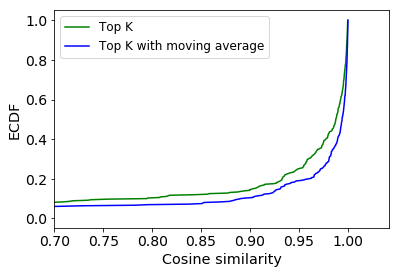

In [20]:
#gw_table_similarity_ma.set_index(pd.DatetimeIndex(gw_table_similarity_ma['timestamp']))
#gw_table_similarity.set_index(pd.DatetimeIndex(gw_table_similarity['timestamp']))
#gw_table_similarity_ma_top.set_index(pd.DatetimeIndex(gw_table_similarity_ma_top['timestamp']))

gw_table_similarity_no_ma.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma['timestamp']))
gw_table_similarity_no_ma_top4.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma_top4['timestamp']))

getECDF(gw_table_similarity_no_ma_top4).plot(color='green')
#getECDF(gw_table_similarity_no_ma_top5).plot(color='blue')
#getECDF(gw_table_similarity_no_ma_top6).plot(color='orange')
#getECDF(gw_table_similarity_no_ma_top7).plot(color='cyan')

#getECDF(gw_table_similarity).plot(color='red')
#getECDF(gw_table_similarity_no_ma).plot(color='red')

getECDF(gw_table_similarity_ma_top).plot(color='blue')

plt.legend(['Top K', 'Top K with moving average'], fontsize = 'large')
plt.ylabel('ECDF', fontsize = 'x-large')
plt.xlabel('Cosine similarity', fontsize = 'x-large')

plt.xlim(0.7)

plt.tick_params(axis='both', which='major', labelsize=14)
#plot.tick_params(axis='both', which='minor', labelsize=8)


plt.show()

In [253]:
temp =  pd.read_csv(os.path.join('error_transitive_pattern_8clients.csv'), sep=',', index_col='timestamp')
temp.head()

,error 5%,error 10%,error 15%
timestamp,,,
"01/21/2019, 14:32:00",0.967222,0.997620,0.994969
"01/21/2019, 14:34:00",0.999411,0.942722,0.992565
"01/21/2019, 14:36:00",0.995073,0.998207,0.999553
"01/21/2019, 14:38:00",0.998500,0.998539,0.998575
"01/21/2019, 14:40:00",0.997737,0.996231,0.994152


In [254]:
def getECDF1(df, col):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[col].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

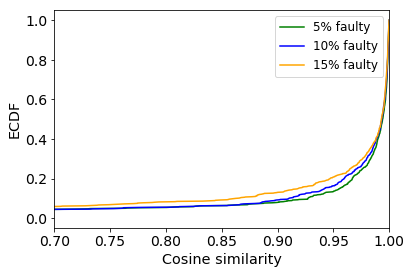

In [256]:
getECDF1(temp, 'error 5%').plot(color='green')
getECDF1(temp, 'error 10%').plot(color='blue')
getECDF1(temp, 'error 15%').plot(color='orange')
#getECDF1(temp, 'no error').plot(color='red')

plt.legend(['5% faulty', '10% faulty', '15% faulty', 'no error'], fontsize = 'large')
plt.ylabel('ECDF', fontsize = 'x-large')
plt.xlabel('Cosine similarity', fontsize = 'x-large')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(0.7,1)
plt.show()

In [352]:
def change_error_pattern(clients):
    temp = data
    for client in clients:        
        df = temp[client]
        for index, grouped in df.groupby('gateway'):
            df_t = grouped.head(1440)
            cnt = 0
            for index1, row in df_t.iterrows():
                if cnt>5:
                    df.set_value(index.strftime("%m/%d/%Y %H:%M:%S"),'latency', row['latency']*10)
                if cnt == 10:
                    cnt =0
                cnt+=1
            
def change_error_gradual(clients):
    for client in clients:
        df_main = data[client]
        last = None
        for name, grouped in df_main.groupby('gateway'):
            df = grouped.head(100)
            #print(name)
            start = 10
            for index1, row in df.iterrows():
               # print(index1)
                #print(df_main[index1.strftime("%m/%d/%Y %H:%M:%S")][df_main['gateway']==name])
                df.set_value(index1.strftime("%m/%d/%Y %H:%M:%S"),'latency',  (row['latency'] + (row['latency']*start)/100))
                start += 1
            print(df)
            #df.reset_index(inplace=True)
            df_main.update(df['latency'], overwrite=True)
            #print('coming')
            last = index
        

change_error_gradual(['c1_1'])


/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/khulan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                              timestamp      ttfb   latency        gateway  \
timestamp                                                                    
2019-01-21 14:54:00 2019-01-21 14:54:00  0.007046  0.058999  10.138.120.66   
2019-01-21 14:55:00 2019-01-21 14:55:00  0.006939  0.059030  10.138.120.66   
2019-01-21 14:56:00 2019-01-21 14:56:00  0.007221  0.062392  10.138.120.66   
2019-01-21 14:57:00 2019-01-21 14:57:00  0.006945  0.071146  10.138.120.66   
2019-01-21 14:58:00 2019-01-21 14:58:00  0.006735  0.061959  10.138.120.66   
2019-01-21 14:59:00 2019-01-21 14:59:00  0.006508  0.064252  10.138.120.66   
2019-01-21 15:00:00 2019-01-21 15:00:00  0.006782  0.069863  10.138.120.66   
2019-01-21 15:01:00 2019-01-21 15:01:00  0.006826  0.067048  10.138.120.66   
2019-01-21 15:02:00 2019-01-21 15:02:00  0.006758  0.079352  10.138.120.66   
2019-01-21 15:03:00 2019-01-21 15:03:00  0.006832  0.073796  10.138.120.66   
2019-01-21 15:04:00 2019-01-21 15:04:00  0.006864  0.078648  10.

ValueError: cannot reindex from a duplicate axis

In [351]:

for name, grouped in data['c1_1'].groupby('gateway'):
    df = grouped.head(20)
    print(df[['latency','gateway']])

                      latency        gateway
timestamp                                   
2019-01-21 14:54:00  0.031052  10.138.120.66
2019-01-21 14:55:00  0.030906  10.138.120.66
2019-01-21 14:56:00  0.032496  10.138.120.66
2019-01-21 14:57:00  0.036863  10.138.120.66
2019-01-21 14:58:00  0.031938  10.138.120.66
2019-01-21 14:59:00  0.032950  10.138.120.66
2019-01-21 15:00:00  0.035645  10.138.120.66
2019-01-21 15:01:00  0.034034  10.138.120.66
2019-01-21 15:02:00  0.040077  10.138.120.66
2019-01-21 15:03:00  0.037084  10.138.120.66
2019-01-21 15:04:00  0.039324  10.138.120.66
2019-01-21 15:05:00  0.038427  10.138.120.66
2019-01-21 15:06:00  0.039934  10.138.120.66
2019-01-21 15:07:00  0.041910  10.138.120.66
2019-01-21 15:08:00  2.034229  10.138.120.66
2019-01-21 15:09:00  0.041807  10.138.120.66
2019-01-21 15:10:00  0.044022  10.138.120.66
2019-01-21 15:11:00  0.046457  10.138.120.66
2019-01-21 15:12:00  0.042553  10.138.120.66
2019-01-21 15:13:00  0.047908  10.138.120.66
          